In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from datasets import get_list_of_clients_ctscan
from utils import generate_samples
from methods import central, local, federated
from methods import personalized_errors_cv_alpha, personalized_topk_cv_alpha

In [3]:
n_nodes = 50
n_test = 100
gamma = 1.
seed = 123
prob_law = "log_normal_low_var"
error_func = mean_squared_error
base_model = Ridge(alpha=0.1, fit_intercept=False)

df = pd.read_csv("https://archive.ics.uci.edu/static/public/206/relative+location+of+ct+slices+on+axial+axis.zip")

data_list = get_list_of_clients_ctscan(df)

In [4]:
X_train, Y_train, X_test, Y_test, n_train, _ = generate_samples(
                                                        data_list,
                                                        gamma=gamma,
                                                        n_nodes=n_nodes,
                                                        prob_law=prob_law,
                                                        n_test=n_test,
                                                        seed=seed)

In [5]:
np.random.seed(seed)
indice_test = np.random.choice(n_nodes, int(np.ceil(n_nodes*0.05)), replace=False)
dict_models = {}

for method in [central, local, federated, personalized_errors_cv_alpha,
                                   personalized_topk_cv_alpha]:

    if "personalized" in method.__name__:
        models = method(base_model, X_train, Y_train,
                        X_test, Y_test, indice_test=indice_test, 
                        error_func=error_func)
    else:
        models = method(base_model, X_train, Y_train)
        
    dict_models[method.__name__] = models

Alpha: 100000 Score: 0.11297575747946005
Alpha: 10000 Score: 0.11291434541936911
Alpha: 1000 Score: 0.11230137621223886
Alpha: 100 Score: 0.10628682351888603
Alpha: 10 Score: 0.05905585221444574
Alpha: 1 Score: 0.009088242147046554
Alpha: 0.1 Score: 0.00998465620570914
Alpha: 0.01 Score: 0.013482133456034951
Alpha: 0.001 Score: 0.013266805220746913
Alpha: 0.0001 Score: 0.01345038846735301
K: 1 Score: 0.05482520161079973
K: 10 Score: 0.10243324313990525
K: 50 Score: 0.13169651112804162
K: 100 Score: 0.13169651112804162


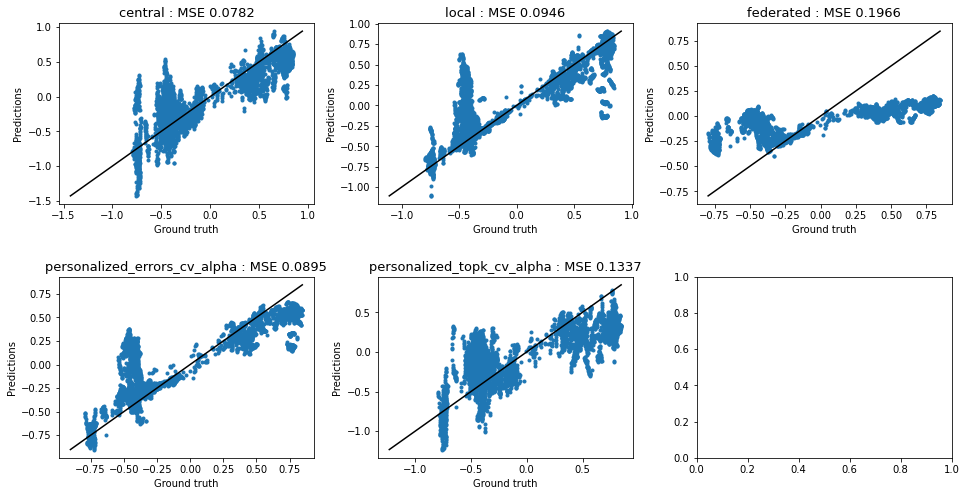

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for name, ax in zip(dict_models, axes.ravel()):
    y_pred = np.concatenate([m.predict(X) for m, X in zip(dict_models[name], X_test)])
    y_true = np.concatenate(Y_test)
    
    xmin, xmax = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    ax.plot(y_true, y_pred, ".")
    ax.plot([xmin, xmax], [xmin, xmax], c="k")
    score = mean_squared_error(y_true, y_pred)
    ax.set_xlabel("Ground truth")
    ax.set_ylabel("Predictions")
    ax.set_title("%s : MSE %.4f"%(name, score), fontsize=13)

plt.subplots_adjust(wspace=0.25, hspace=0.4)
plt.show()